In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (11,6)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 12

## Problem 1

We have some function $f(x)$ sampled at four points: $f(x\pm\delta)$ and $f(x\pm2\delta)$. We can use these points to estimate the derivative of $f$ at $x$ by examining the Taylor expansion of $f$ near $x$:
  
$$
f(x \pm n\delta) = f(x) \pm n\delta f'(x) + \frac{(n\delta)^2}{2}f''(x) \pm \frac{(n\delta)^3}{6} f'''(x) + \cdots,
$$
  
where $\delta \ll 1$. From the Taylor expansion, it follows that
  
$$
\Delta f_1 \equiv f(x+\delta) - f(x-\delta) \approx 2\delta f'(x) + \frac{\delta^3}{3} f'''(x) + \cdots
$$
  
and
  
$$
\Delta f_2 \equiv f(x+2\delta) - f(x-2\delta) \approx 4\delta f'(x) + \frac{8\delta^3}{3} f'''(x) + \cdots.
$$
  
Note that we can make our estimation of $f'(x)$ good to fourth order with the following combination of $\Delta f_1$ and $\Delta f_2$:
  
$$
f'(x) \approx \frac{8\Delta f_1 - \Delta f_2}{12\delta}.
$$
  
An implementation of this approximation is provided in the following cells. Note that we are unable to estimate the derivative at the first and last two sample points, and that this implementation will likely not give a great estimate of the derivative for irregularly sampled data.

In [62]:
def estimate_derivative(x, y):
    """
    Estimate the derivative of y(x).
    
    This function estimates the derivative of y(x) at each
    x in x[2:-2] using four sample points, y(x+dx), y(x-dx),
    y(x+2dx), and y(x-2dx). The derivative y'(x) is approximately
    y'(x) ~ (8y(x+dx) - 8y(x-dx) - y(x+2dx) + y(x-2dx))/12dx.
    
    Parameters
    ----------
    x: array-like of float
        Values the function is evaluated at.
        
    y: array-like of float
        Function evaluated at each x.
        
    Returns
    -------
    dydx_approx: ndarray
        Approximation of the derivative of y at x[2:-2].
    """
    x = np.array(x)
    y = np.array(y)
    dx = np.mean(np.diff(x))
    Dy1 = y[3:-1] - y[1:-3]
    Dy2 = y[4:] - y[:-4]
    return (8 * Dy1 - Dy2) / (12 * dx)

In [65]:
x = np.linspace(-1, 1, 10)
y = np.exp(0.01 * x)
dydx = estimate_derivative(x,y)
true_derivative = 0.01 * y
error = np.std(true_derivative[2:-2] - dydx)

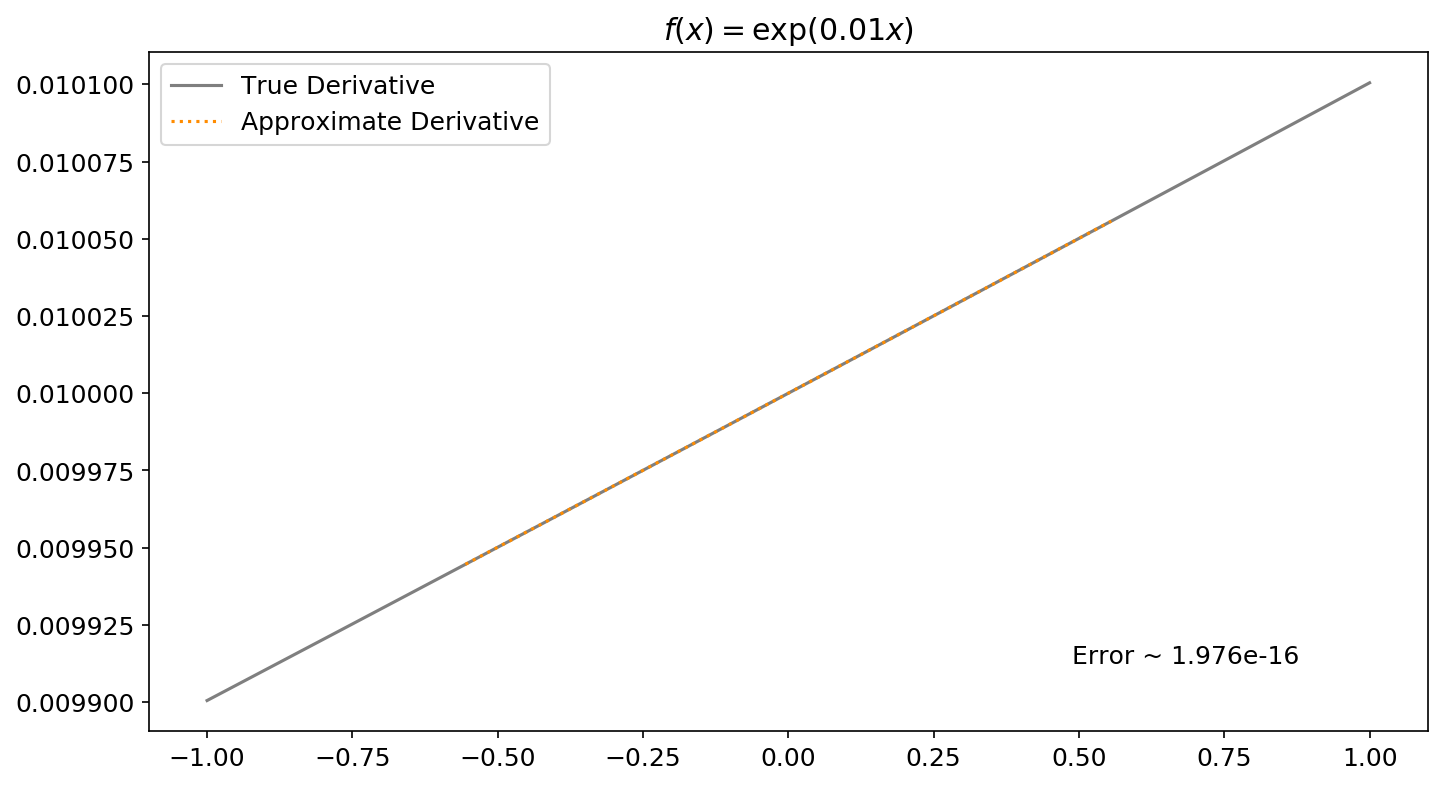

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r"$f(x) = $exp$(0.01x)$")
ax.plot(x, true_derivative, color="k", label="True Derivative", alpha=0.5)
ax.plot(x[2:-2], dydx, color="darkorange", label="Approximate Derivative", ls=":")
ax.text(0.9, 0.1, f"Error ~ {error:.3e}", transform=ax.transAxes, horizontalalignment="right")
ax.legend();

In [67]:
x = np.linspace(-1, 1, 10)
y = x ** 3 - 2 * x ** 2
true_derivative = 3 * x ** 2 - 4 * x
dydx = estimate_derivative(x, y)
error = np.std(true_derivative[2:-2] - dydx)

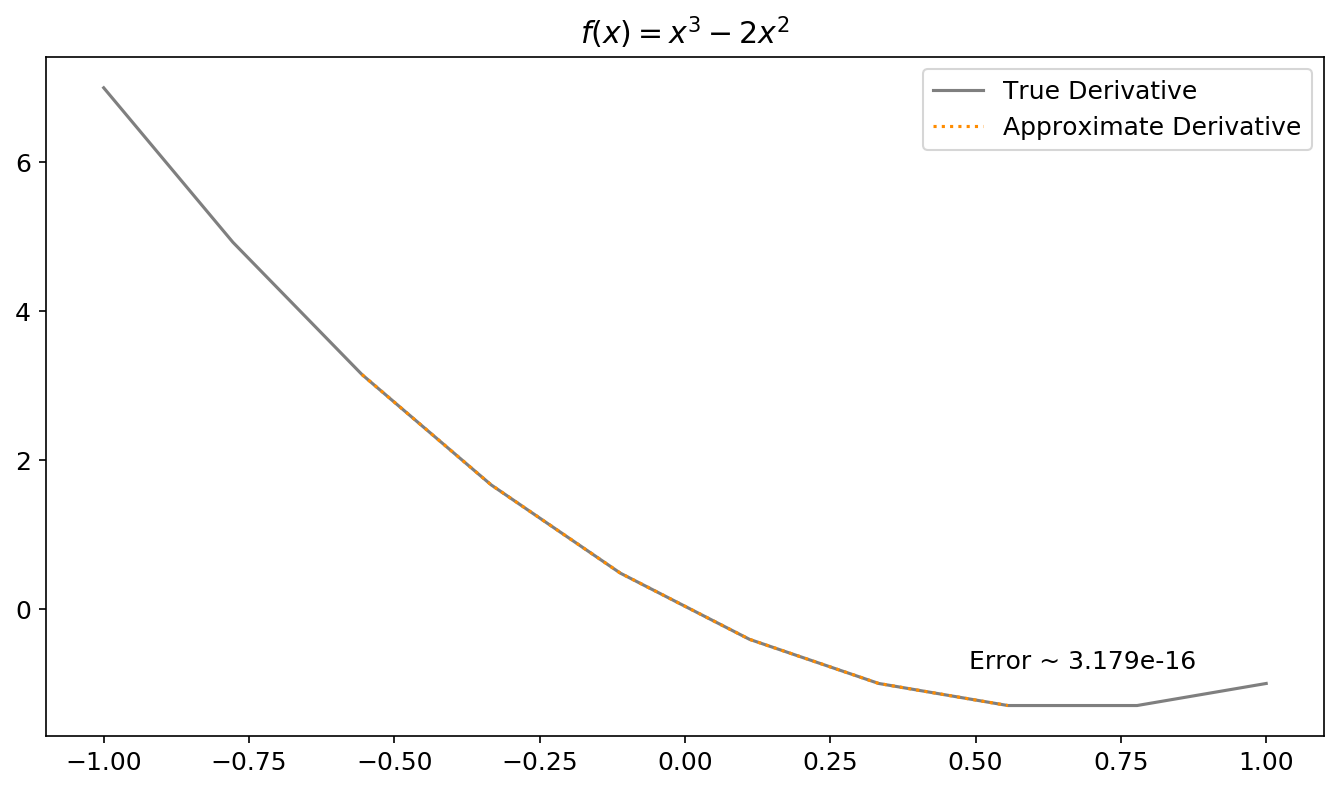

In [68]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r"$f(x) = x^3 - 2x^2$")
ax.plot(x, true_derivative, color="k", label="True Derivative", alpha=0.5)
ax.plot(x[2:-2], dydx, color="darkorange", label="Approximate Derivative", ls=":")
ax.text(0.9, 0.1, f"Error ~ {error:.3e}", transform=ax.transAxes, horizontalalignment="right")
ax.legend();

Now on to choosing the optimal step size $\delta$. We want to minimize the error in $f'(x)$ with respect to our choice of step size. Playing fast-and-loose with the examples from class, I claim that the error can be written as
  
$$
\mathcal{E} = \frac{\epsilon f(x)}{12\delta} + \frac{\delta^5 f^V(x)}{5},
$$
  
with $\epsilon$ being the machine precision error. We can minimize the error with respect to step size $\delta$ by choosing
  
$$
\delta = \biggl(\frac{\epsilon f(x)}{24f^V(x)}\biggr)^{1/6}.
$$
  
Note that this isn't terribly useful if we can't find some function similar to $f$ that we can work with analytically to estimate $f^V$. That said, we're considering the case of an exponential, so $f^{(n)}(x) = f(x)$, and we can estimate the ideal step size as
  
$$
\delta_0 \approx (\epsilon_0/24)^{1/6}.
$$

In [80]:
# for double-precision floats, machine error ~ 1e-16, so
scales = (1, 0.01)
ideal_step_sizes = [(1e-16 / (scale ** 5 * 24)) ** (1 / 6) for scale in scales]
errors = {scale: np.zeros_like(step_sizes) for scale in scales}
for scale, ideal_step_size in zip(scales, ideal_step_sizes):
    start_step_size = ideal_step_size * 1e-2
    end_step_size = ideal_step_size * 10
    step_sizes = np.logspace(np.log2(start_step_size), np.log2(end_step_size), num=20, base=2)
    for j, step_size in enumerate(step_sizes):
        xvals = np.arange(0, 10, step_size)
        yvals = {key: np.exp(key * xvals) for key in scales}
        est_deriv = {key: estimate_derivative(xvals, ys) for key, ys in yvals.items()}
        for scale in scales:
            errors[scale][j] = np.std(scale * yvals[scale][2:-2] - est_deriv[scale])

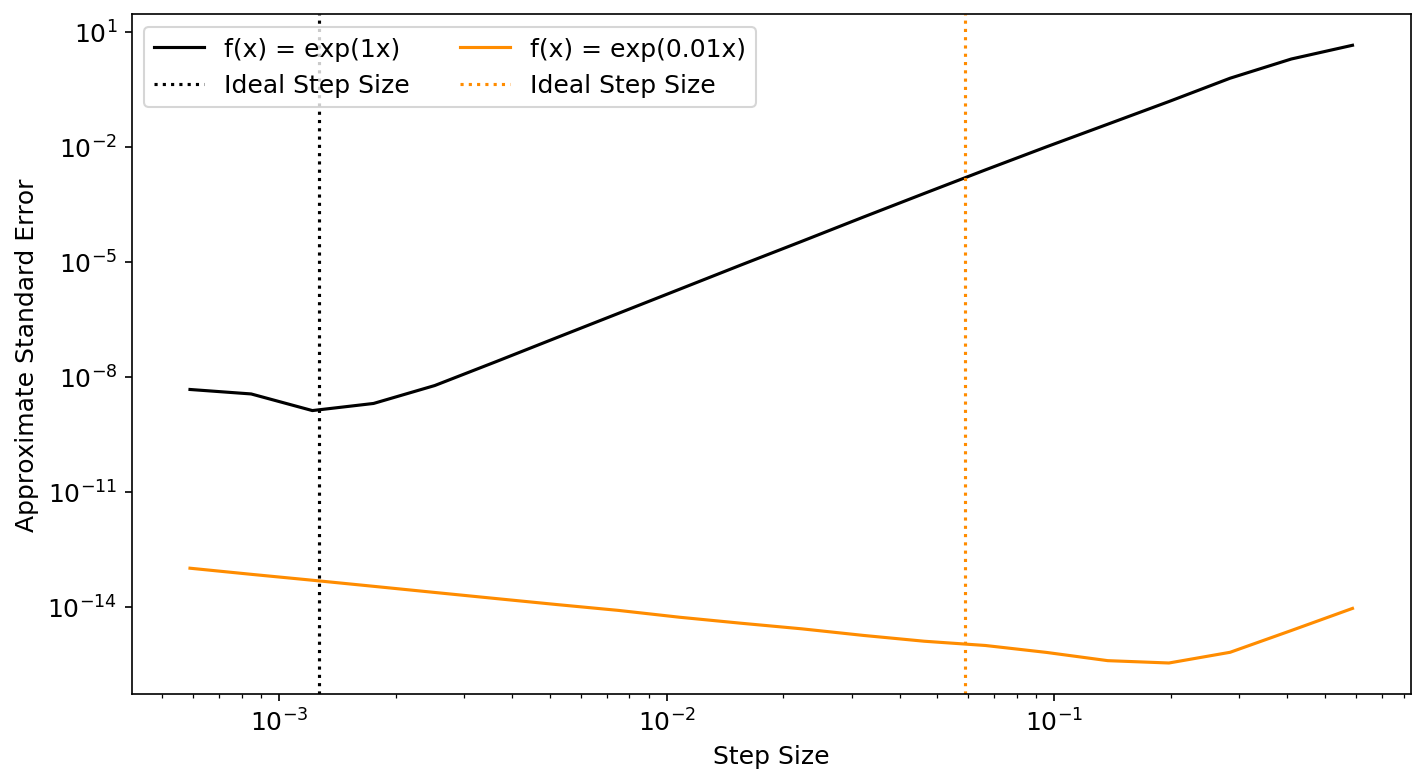

In [85]:
colors = dict(zip(scales, ("k", "darkorange")))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Step Size")
ax.set_ylabel("Approximate Standard Error")
for j, (scale, err) in enumerate(errors.items()):
    ax.loglog(step_sizes, err, label=f"f(x) = exp({scale}x)", color=colors[scale])
    ax.axvline(ideal_step_sizes[j], ls=":", color=colors[scale], label="Ideal Step Size")
ax.legend(ncol=2);

It looks like the approximation for the ideal step size was pretty spot-on for $e^x$, but was a bit of an under-estimate for $e^{0.01x}$.

## Problem 2

For this problem, we need to write an interpolation function that will convert an input voltage to a temperature, according to measurements provided for the Lakeshore 670 diode. To do this, I will load in the data from the provided `lakeshore.txt` file and ~use a cubic spline interpolator from `scipy` in order to actually perform the interpolation~ write a simple linear interpolator to estimate the temperature.

In [8]:
data = np.genfromtxt("lakeshore.txt")
# Reverse the order so that the voltages are increasing.
temperatures = data[:,0][::-1]
voltages = data[:,1][::-1]
dVdT = data[:,2][::-1]
assert np.all(voltages[1:] > voltages[:-1])

In [9]:
def estimate_temperature(voltage):
    """
    Estimate the temperature given a voltage for the Lakeshore 670 diode.
    
    Parameters
    ----------
    voltage: array-like of float
        Voltage(s), in Volts, at which to estimate the corresponding temperature,
        in Kelvin.
        
    Returns
    -------
    temperature: ndarray of float
        Temperature(s), in Kelvin, corresponding to the input voltage(s).
    lower_uncertainty: ndarray of float
        Lower uncertainty in the estimated temperature, in Kelvin. (Lower half
        of the error bar.)
    upper_uncertainty: ndarray of float
        Upper uncertainty of the estimated temperature, in Kelvin. (Upper half
        of the error bar.)
    """
    voltage = np.atleast_1d(voltage)
    if any(volt < voltages.min() or volt > voltages.max() for volt in voltage):
        raise ValueError("Extrapolation not supported.")
    
    # Maybe stupid implementation, but the idea here is that we'll use the
    # rate of change of V(T) to estimate the uncertainty. To do that, we'll find
    # the nearest voltages above and below the input voltages, calculate the difference
    # between the measured and input voltages for each of these two sets, then estimate
    # the uncertainty as dT ~ dV / (dV/dT) for each of these sets.
    upper_uncertainties = []
    lower_uncertainties = []
    temperature = []
    for volt in voltage:
        # To minimize repeated code.
        upper_key = voltages >= volt
        lower_key = voltages <= volt
        
        # Get V, T at voltages just above and below desired voltage.
        upper_voltage = voltages[upper_key][0]
        lower_voltage = voltages[lower_key][-1]
        upper_temperature = temperatures[upper_key][0]
        lower_temperature = temperatures[lower_key][-1]
        
        # Calculate parameters for the slope of the line T(V) near this voltage.
        dV = upper_voltage - lower_voltage
        dT = upper_temperature - lower_temperature
        
        # Get the distance between the nearest measured voltages for error estimation.
        dV_upper = volt - upper_voltage
        dV_lower = volt - lower_voltage
        
        # Actually estimate the temperature with uncertainties.
        temperature.append(lower_temperature + dT * dV_lower / dV)
        upper_uncertainties.append(np.abs(dV_upper * dVdT[upper_key][0]))
        lower_uncertainties.append(np.abs(dV_lower * dVdT[lower_key][-1]))
    
    # Ensure that all return values are ndarrays.
    temperature = np.array(temperature)
    upper_uncertainties = np.array(upper_uncertainties)
    lower_uncertainties = np.array(lower_uncertainties)
    return temperature, lower_uncertainties, upper_uncertainties

In [10]:
# Test it by looking at the midpoints of the measured voltages.
input_voltages = 0.5 * (voltages[1:] + voltages[:-1])
(
    estimated_temperatures,
    lower_uncertainties,
    upper_uncertainties,
) = estimate_temperature(input_voltages)
uncertainties = np.vstack([lower_uncertainties, upper_uncertainties])

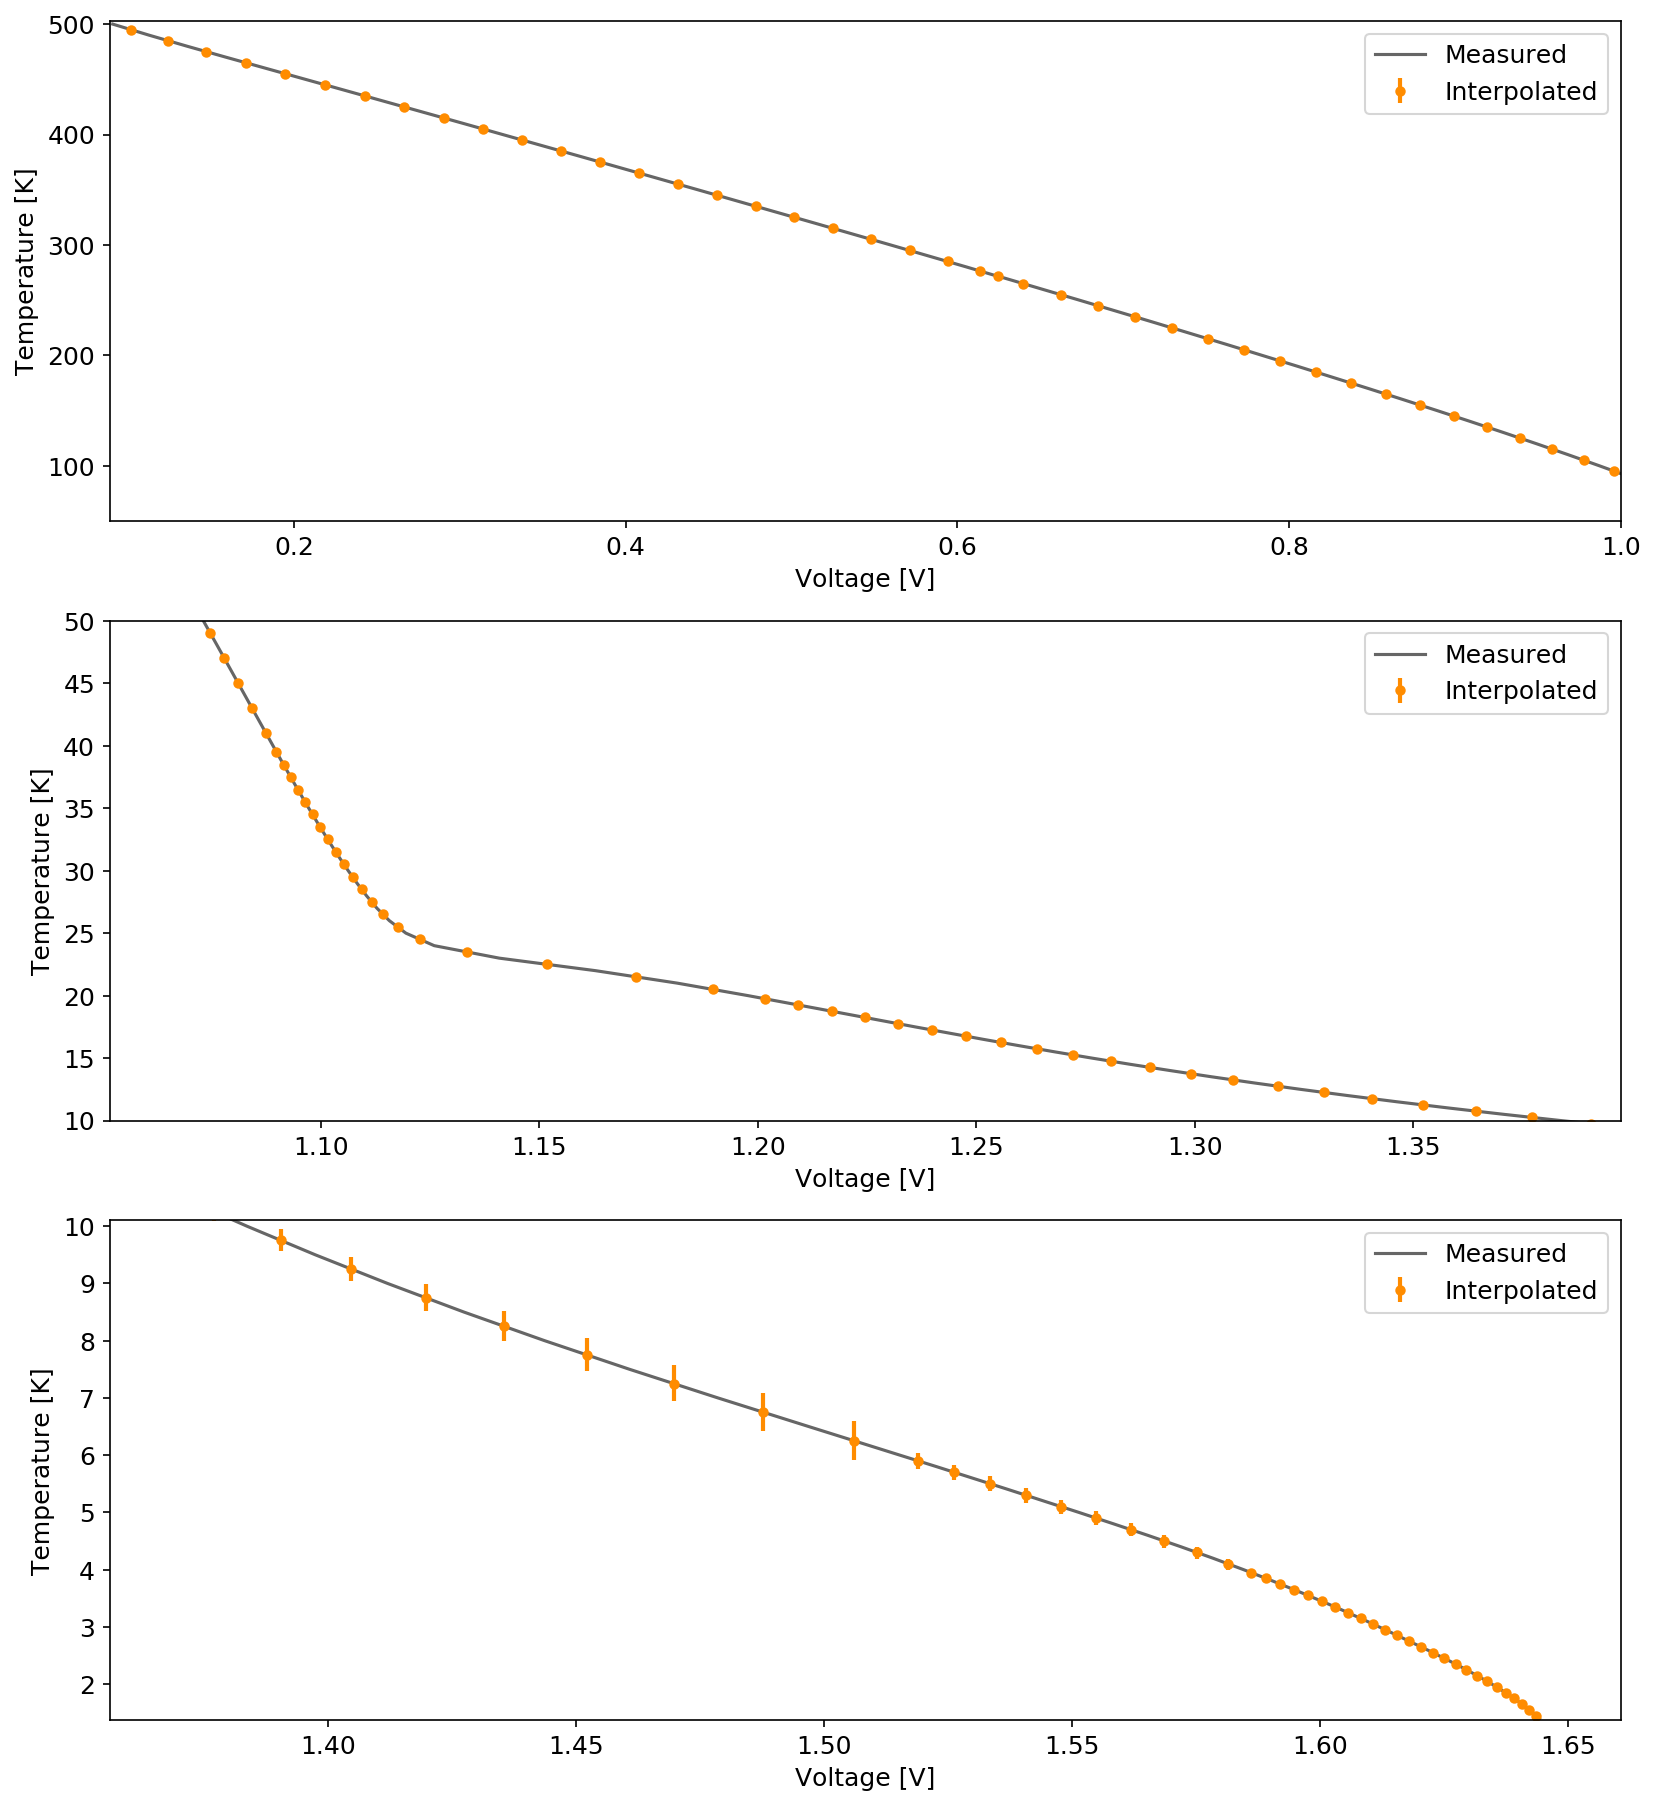

In [11]:
# For choosing plotting windows
T1 = 50
T2 = 10
V1 = voltages[np.argmin(np.abs(temperatures - T1))]
V2 = voltages[np.argmin(np.abs(temperatures - T2))]

# Make a stack of three plots showing different regimes
fig = plt.figure(figsize=(13,15))
axes = fig.subplots(3)
for ax in axes:
    ax.set_xlabel("Voltage [V]")
    ax.set_ylabel("Temperature [K]")
    ax.plot(voltages, temperatures, color="k", alpha=0.6, label="Measured")
    ax.errorbar(
        input_voltages, estimated_temperatures, yerr=uncertainties,
        color="darkorange", lw=0, marker="o", ms=4, label="Interpolated",
        ecolor="darkorange", elinewidth=2
    )
    ax.legend()
    
# Configure the axes appropriately.
axes[0].set_xlim(0.98 * voltages.min(), 1)
axes[0].set_ylim(50, 1.005 * temperatures.max())
axes[1].set_xlim(0.98 * V1, 1.01 * V2)
axes[1].set_ylim(T2, T1)
axes[2].set_xlim(0.98 * V2, 1.01 * voltages.max())
axes[2].set_ylim(0.98 * temperatures.min(), 1.01 * T2);

Looks like the linear interpolation does very well for this set of data, with basically every point agreeing with the expected value (of course up to the interpolation that `matplotlib` does under the hood).

## Problem 3

In [145]:
# Adaptation of rational function fitting code from class
def rational_func(p, q, x):
    """
    Parameters
    ----------
    p: array-like of float
        Coefficients of the polynomial in the numerator, starting from
        the degree-0 coefficient.
    q: array-like of float
        Coefficients of the polynomial in the denominator, starting from 
        the degree-1 coefficient.
    x: array-like of float
        x-values at which to evaluate the rational function.
    
    Returns
    -------
    f: ndarray of float
        Rational function evaluated at provided x-values.
    """
    numerator = 0
    for i, coeff in enumerate(p):
        numerator += coeff * x ** i
    denominator = 1
    for i, coeff in enumerate(q):
        denominator += coeff * x ** i
    #numerator = np.polyval(p[::-1], x)
    #q = np.append(np.atleast_1d(q).flatten(), 1)
    #denominator = np.polyval(q[::-1], x)
    return numerator / denominator

def rational_fit(x, y, n, m, use_pinv=False):
    """
    Parameters
    ----------
    x: array-like of float
        x-values at which the function y is evaluated.
    y: array-like of float
        Function evaluated at provided x-values.
    n: int
        Degree of the polynomial used in the numerator.
    m: int
        Degree of the polynomial used in the denominator.
        
    Returns
    -------
    p, q: ndarray of float
        Coefficients for the polynomials used in the numerator/denominator.
    """
    assert len(x) == n + m - 1
    assert len(x) == len(y)
    inv = np.linalg.pinv if use_pinv else np.linalg.inv
    order = n + m - 1
    mat = np.zeros((order, order))
    for i in range(n):
        mat[:,i] = x ** i
    for i in range(1,m):
        mat[:,i-1+n] = -y * x ** i
    try:
        coeffs = inv(mat) @ y
    except np.linalg.LinAlgError:
        print("Singular Matrix. Returning ones.")
        coeffs = np.ones_like(y)
    return coeffs[:n], coeffs[n:]

In [146]:
# Look at the various fits for cos(x) on [-pi/2, pi/2]
n, m = 3, 7
xvals = np.linspace(-np.pi / 2, np.pi / 2, n + m - 1)
test_points = np.linspace(xvals.min(), xvals.max(), 100)
yvals = np.cos(xvals)
truth = np.cos(test_points)
polyfit = np.polyfit(xvals, yvals, max(n, m))
y_polyfit = np.polyval(polyfit, test_points)
spline = interp1d(xvals, yvals, kind="cubic")
y_spline = spline(test_points)
ratfit = rational_fit(xvals, yvals, n, m)
ratfit_pinv = rational_fit(xvals, yvals, n, m, True)
y_ratfit = rational_func(ratfit[0], ratfit[1], test_points)
y_ratfit_pinv = rational_func(ratfit_pinv[0], ratfit_pinv[1], test_points)

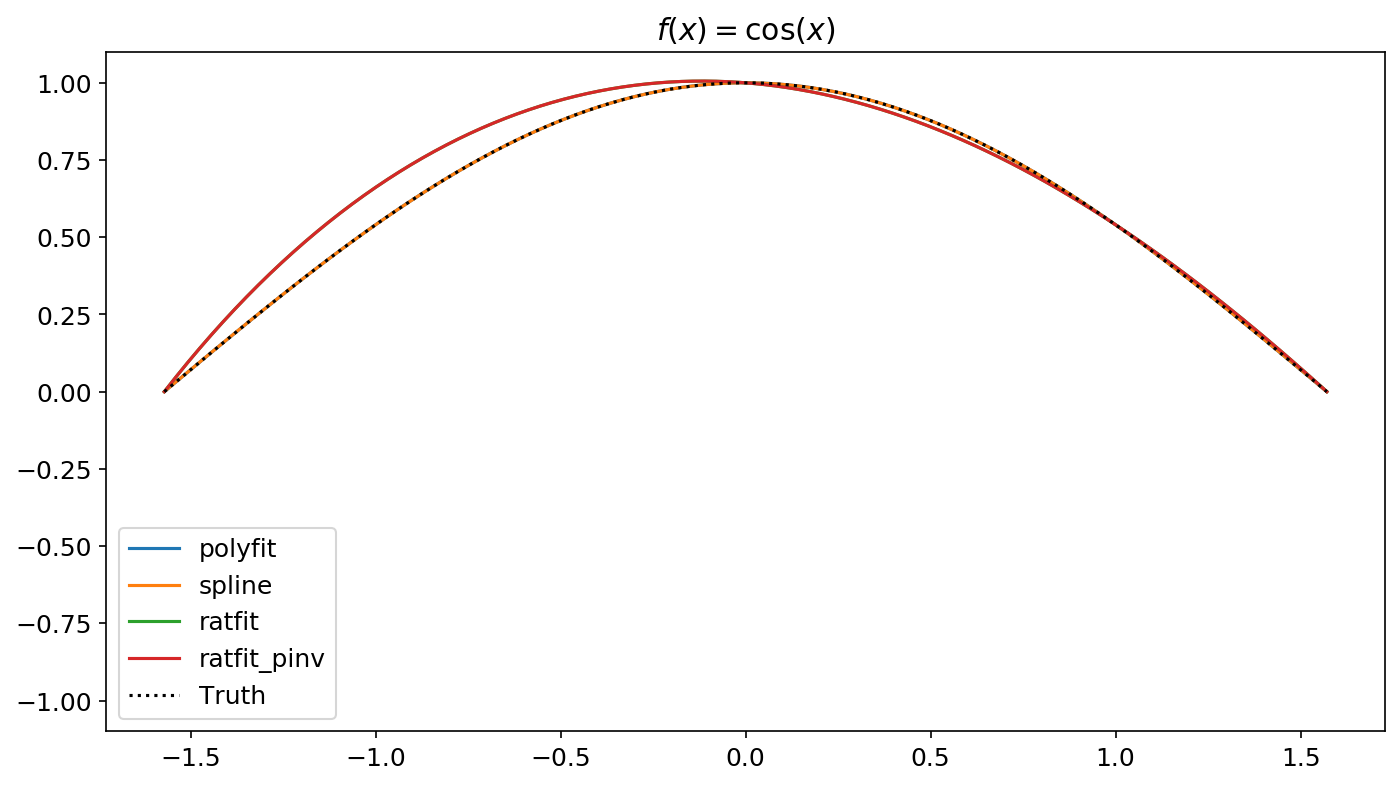

In [147]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r"$f(x) = \cos(x)$")
ax.set_ylim(-1.1,1.1)
fits = {
    "polyfit": y_polyfit,
    "spline": y_spline,
    "ratfit": y_ratfit,
    "ratfit_pinv": y_ratfit_pinv
}
for label, ys in fits.items():
    ax.plot(test_points, ys, label=label)
ax.plot(test_points, truth, label="Truth", color="k", ls=":")
ax.legend();

Apparently the rational function fit (using the pseudo-inverse or not) doesn't do super well with cosine. The polynomial and spline work well, but that's sort of expected given how cosine looks on the interval in question.

In [148]:
# Shameless copypasta of above with slight modifications to look at a Lorentzian
# Look at the various fits for 1/(1+x^2) on [-1, 1]
n, m = 4, 5
xvals = np.linspace(-1, 1, n + m - 1)
test_points = np.linspace(xvals.min(), xvals.max(), 100)
yvals = 1 / (1 + xvals ** 2)
truth = 1 / (1 + test_points ** 2)
polyfit = np.polyfit(xvals, yvals, max(n, m))
y_polyfit = np.polyval(polyfit, test_points)
spline = interp1d(xvals, yvals, kind="cubic")
y_spline = spline(test_points)
ratfit = rational_fit(xvals, yvals, n, m)
ratfit_pinv = rational_fit(xvals, yvals, n, m, True)
y_ratfit = rational_func(ratfit[0], ratfit[1], test_points)
y_ratfit_pinv = rational_func(ratfit_pinv[0], ratfit_pinv[1], test_points)

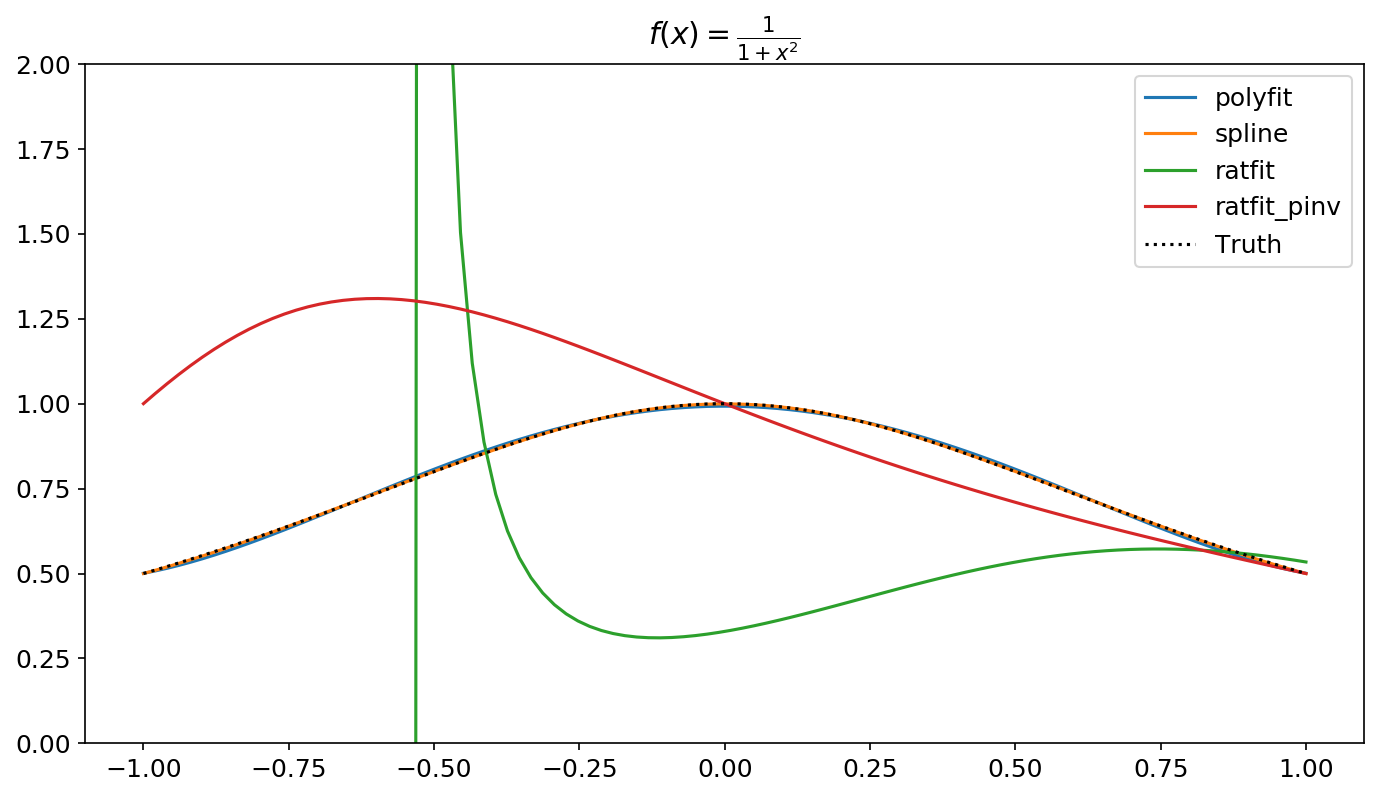

In [149]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r"$f(x) = \frac{1}{1+x^2}$")
ax.set_ylim(0, 2)
fits = {
    "polyfit": y_polyfit,
    "spline": y_spline,
    "ratfit": y_ratfit,
    "ratfit_pinv": y_ratfit_pinv
}
for label, ys in fits.items():
    ax.plot(test_points, ys, label=label)
ax.plot(test_points, truth, label="Truth", color="k", ls=":")
ax.legend();

Well, this is pretty wacky. I was honestly expecting the rational fit to be better than the polynomial/spline fits, though I also expected the Lorentzian to be peaked more sharply than it is. That aside, the rational fit should be perfect for the Lorentzian, as long as the parameters are chosen correctly. Let's look at the polynomials.

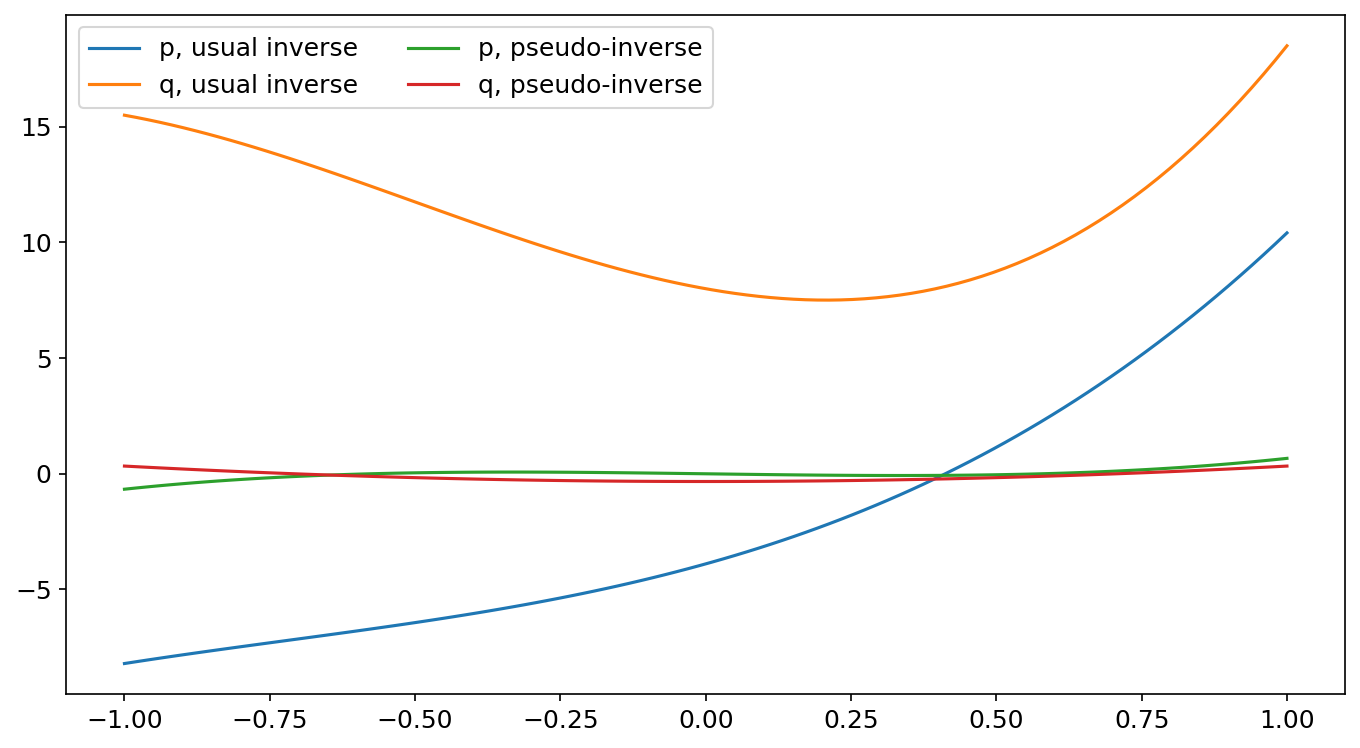

In [150]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(test_points, np.polyval(ratfit[0], test_points), label="p, usual inverse")
ax.plot(test_points, np.polyval(ratfit[1], test_points), label="q, usual inverse")
ax.plot(test_points, np.polyval(ratfit_pinv[0], test_points), label="p, pseudo-inverse")
ax.plot(test_points, np.polyval(ratfit_pinv[1], test_points), label="q, pseudo-inverse")
ax.legend(ncol=2);

So, for $n=4, m=5$, it looks like we get a few poles in the rational function fit for both the pseudo-inverse and the usual inverse. That has to be what's making things behave poorly.

In [166]:
# A quick check that I can fit the Lorentzian perfectly with a rational fit.
n, m = 3, 10
xvals = np.linspace(-1, 1, n + m - 1)
test_points = np.linspace(xvals.min(), xvals.max(), 100)
yvals = 1 / (1 + xvals ** 2)
truth = 1 / (1 + test_points ** 2)
polyfit = np.polyfit(xvals, yvals, max(n, m))
y_polyfit = np.polyval(polyfit, test_points)
spline = interp1d(xvals, yvals, kind="linear")
y_spline = spline(test_points)
ratfit = rational_fit(xvals, yvals, n, m)
ratfit_pinv = rational_fit(xvals, yvals, n, m, True)
y_ratfit = rational_func(ratfit[0], ratfit[1], test_points)
y_ratfit_pinv = rational_func(ratfit_pinv[0], ratfit_pinv[1], test_points)

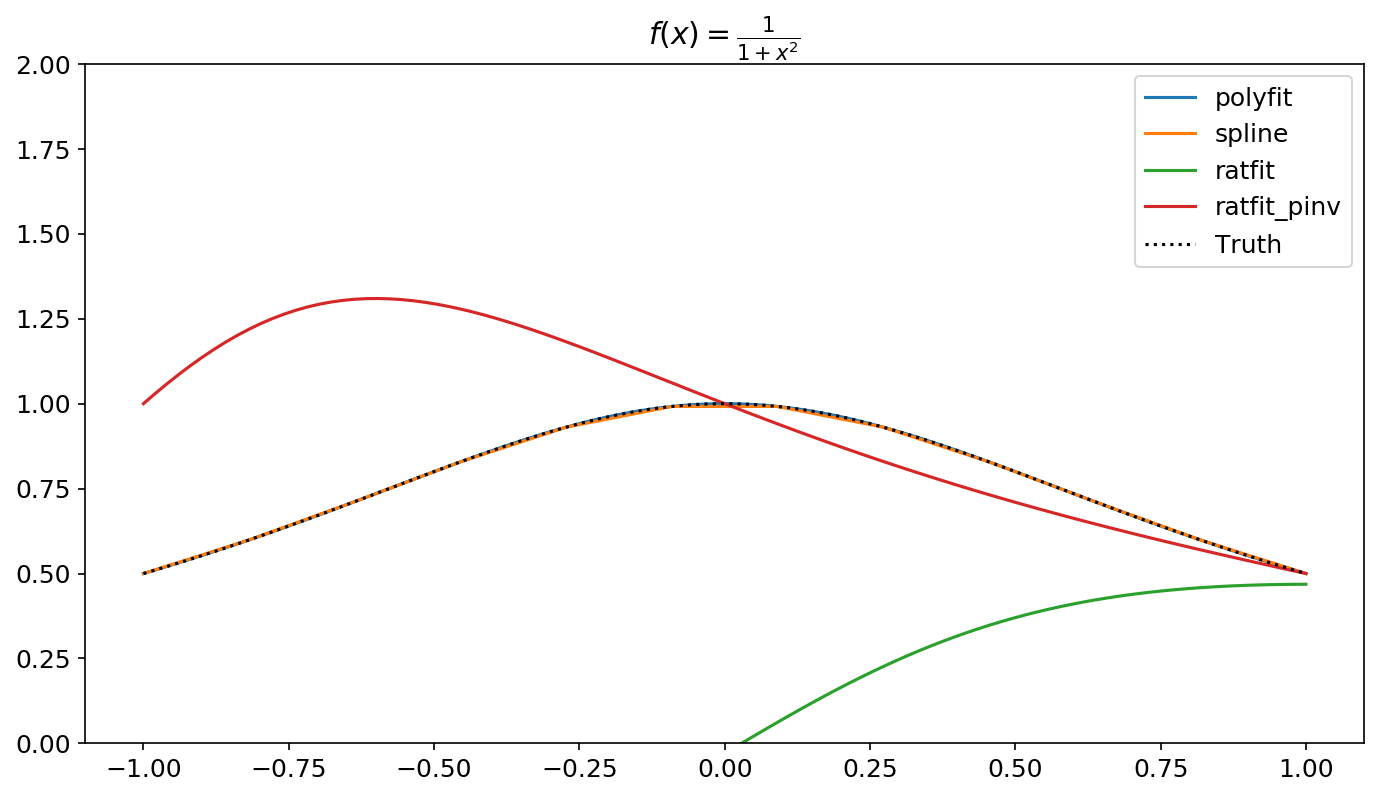

In [167]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r"$f(x) = \frac{1}{1+x^2}$")
ax.set_ylim(0, 2)
fits = {
    "polyfit": y_polyfit,
    "spline": y_spline,
    "ratfit": y_ratfit,
    "ratfit_pinv": y_ratfit_pinv
}
for label, ys in fits.items():
    ax.plot(test_points, ys, label=label)
ax.plot(test_points, truth, label="Truth", color="k", ls=":")
ax.legend();

Hmm.... Seems like I have a bug somewhere, or I'm just being stupid. Either way, I can't seem to make the rational fit work for the Lorentzian, even though it should work perfectly.

## Problem 4

Forgot that I had to actually do physics and only left myself 15 minutes to do this problem. Oops! Guess I'll just work it out some other time.

In [21]:
def integrate(func, dx):
    """
    Integrate a provided function for a given step size using Simpson's Rule.
    
    Parameters
    ----------
    func: array-like of float
        Sampled points of the function to integrate.
    dx: float
        Step size used for partitioning the integration domain.
        
    Returns
    -------
    integral: float
        Approximation of the integral of the input function.
    """
    func = np.array(func)
    if func.size % 2 == 0:
        raise ValueError(
            "An odd number of points is needed for this integration scheme."
        )
        
    weights = np.ones_like(func)
    weights[1::2] = 4
    weights[2:-1:2] = 2
    return weights @ func * dx / 3